In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn import datasets

plot_figures = True
dateAndTime = "2019-02-20-10-26-45/";
filename = '/Users/roberto/data/RO-logging/'+dateAndTime;
print('Reading from: ' + filename)

# Read from files into dataframes
df_xyz_yaw = pd.read_csv(filename+'xyz_yaw.csv',names=range(4))
df_MaxEVec = pd.read_csv(filename+'MaxEVec.csv',names=range(2400))

print("Shape of xyz_yaw is:\n",shape(df_xyz_yaw))
print("Shape of MaxEVec is:\n",shape(df_MaxEVec))

Reading from: /Users/roberto/data/RO-logging/2019-02-20-10-26-45/
Shape of xyz_yaw is:
 (1301, 4)
Shape of MaxEVec is:
 (1301, 2400)


In [3]:
df_xyz_yaw.head()

,0,1,2,3
0,-0.023780,0.000567,0,-0.000159
1,-0.042059,-0.004266,0,-0.000229
2,-0.046227,-0.009999,0,-0.000903
3,-0.055098,-0.016599,0,-0.000296
4,-0.122243,-0.004457,0,0.001583


In [4]:
where_are_NaNs = isnan(df_MaxEVec)
df_MaxEVec[where_are_NaNs] = 0.0
df_MaxEVec.head()

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,0.025431,0.021291,0.024827,0.023659,0.022150,0.022165,0.023700,0.022107,0.022185,0.025520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.025598,0.024083,0.023837,0.023298,0.018402,0.025601,0.024302,0.018183,0.025603,0.025471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.025526,0.023289,0.016092,0.024250,0.025322,0.024954,0.025138,0.025134,0.021519,0.024432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.025174,0.024937,0.018317,0.023408,0.025559,0.022259,0.019205,0.023759,0.024434,0.025229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.025587,0.019178,0.019796,0.023436,0.021517,0.025140,0.025254,0.024602,0.024312,0.025084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
xyz_yaw = np.copy(df_xyz_yaw.values)
max_evec = np.copy(df_MaxEVec.values)
[a,b] = shape(max_evec)
num_instances = a
[m,n] = shape(xyz_yaw)
total_xyz_yaw = zeros([m,n])
velocity = sqrt(xyz_yaw[:,0]**2+xyz_yaw[:,1]**2)

# Getting angle of radar using velocites 
moving_threshold = 1
index_of_moving_position = 0
for i in range(num_instances):
    if(abs(xyz_yaw[i,0]) > moving_threshold or abs(xyz_yaw[i,1]) > moving_threshold):
        index_of_moving_position = i
        print(xyz_yaw[i,0],', ',xyz_yaw[i,1])
        break
print('Index of moving position = ',index_of_moving_position)

# This still sometimes produces wrong angle offsets in that the velocities can come out with opposite sign
# But, this doesn't affect labels (that use absolute value)
if(xyz_yaw[index_of_moving_position,0] > 0):
    angle_offset = pi + arctan(xyz_yaw[index_of_moving_position,0]/xyz_yaw[index_of_moving_position,1]) + pi/2
else:
    angle_offset = arctan(xyz_yaw[index_of_moving_position,0]/xyz_yaw[index_of_moving_position,1]) + pi/2
print(angle_offset)

-1.00138 ,  0.0151493
Index of moving position =  25
0.015127268791814252


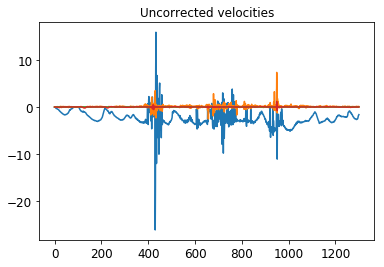

In [6]:
if(plot_figures == True):
    plt.plot(xyz_yaw[:,0:4]);
    plt.title('Uncorrected velocities');

Angle offset =  0.015127268791814252
[[-0.02378626  0.00020715]
 [-0.04199016 -0.00490161]
 [-0.04607086 -0.01069705]
 [-0.05484011 -0.01743014]
 [-0.12216159 -0.00630565]]


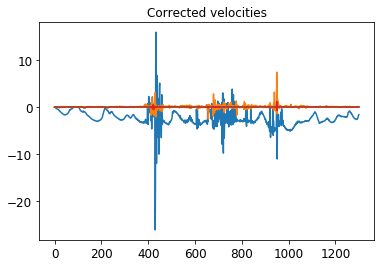

In [7]:
for i in range(1,num_instances):
    total_xyz_yaw[i,3] = total_xyz_yaw[i-1,3] + xyz_yaw[i,3];

RR = np.matrix([[cos(angle_offset), -sin(angle_offset)], [sin(angle_offset), cos(angle_offset)]]);
yaw = zeros(m);
xyz_yaw_world = zeros([m,n]);
for i in range(0,num_instances):
    xyz_yaw[i-1:i, 0:2] = transpose((RR * transpose(xyz_yaw[i-1:i, 0:2])))
    yaw[i] = total_xyz_yaw[i,3] - angle_offset;
    xyz_yaw_world[i,0] = velocity[i]*cos(yaw[i]);
    xyz_yaw_world[i,1] = velocity[i]*sin(yaw[i]);
    
    if(i > 1):
        total_xyz_yaw[i,0] = total_xyz_yaw[i-1,0] + xyz_yaw_world[i,0];
        total_xyz_yaw[i,1] = total_xyz_yaw[i-1,1] + xyz_yaw_world[i,1];
if(plot_figures == True):
    plt.plot(xyz_yaw[:,:]);
    plt.title('Corrected velocities');
    print('Angle offset = ',angle_offset)
# print(RR)
print(xyz_yaw[0:5,0:2])

In [17]:
# Determine if change in velocity for x, y or yaw rate was too large
failure_label = 1 # failures are the positive class, makes classifier implementation easier
label_reach_back = 2 # how many curves to label when failure occurs, 2 will do this curve and previous
max_feasible_x_acc = 1
max_feasible_y_acc = 0.25
max_feasible_angular_acc = 0.1
classification = ones(m)*(-failure_label) # initialise all classifications to be "good"
dxyz_yaw = r_[zeros([1,4]),diff(xyz_yaw,axis=0)]

# Label eigenvector curves, including the curve right before failure
# The preceeding curve seems to indicate failure just before it happens - improves classifier performance
for i in range(num_instances):
    if(abs(dxyz_yaw[i,0]) > max_feasible_x_acc):
        classification[i-label_reach_back:i] = failure_label
    elif(abs(dxyz_yaw[i,1]) > max_feasible_y_acc):
        classification[i-label_reach_back:i] = failure_label
    elif(abs(dxyz_yaw[i,3]) > max_feasible_angular_acc):
        classification[i-label_reach_back:i] = failure_label
        
tally = 0;
for i in range(num_instances):
    if(classification[i] == -1):
        tally+=1
print('Good RO:',tally)
print('Bad RO:',len(classification)-tally)

Good RO: 943
Bad RO: 358


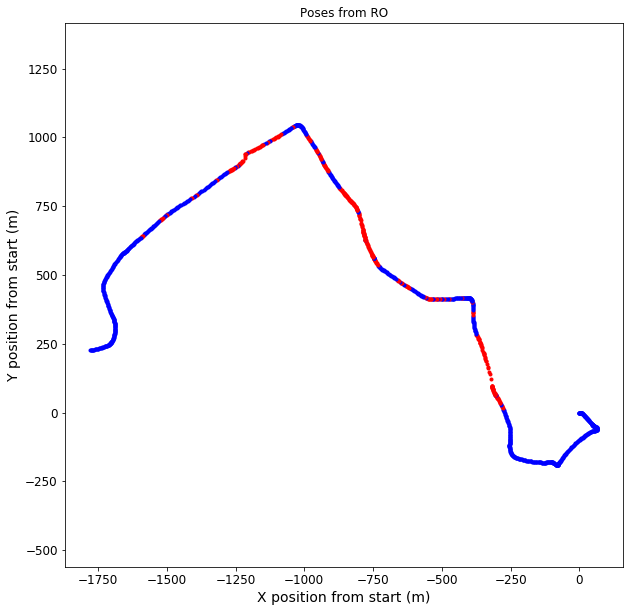

In [14]:
if(plot_figures == True):
    plt.figure(figsize=(10,10))
    for i in range(m):
        if(classification[i] == failure_label):
            plt.plot(total_xyz_yaw[i,0],total_xyz_yaw[i,1],'.',color='red')
        else:
            plt.plot(total_xyz_yaw[i,0],total_xyz_yaw[i,1],'.',color='blue')
    plt.axis('equal');
    plt.title('Poses from RO')
    plt.xlabel('X position from start (m)')
    plt.ylabel('Y position from start (m)')

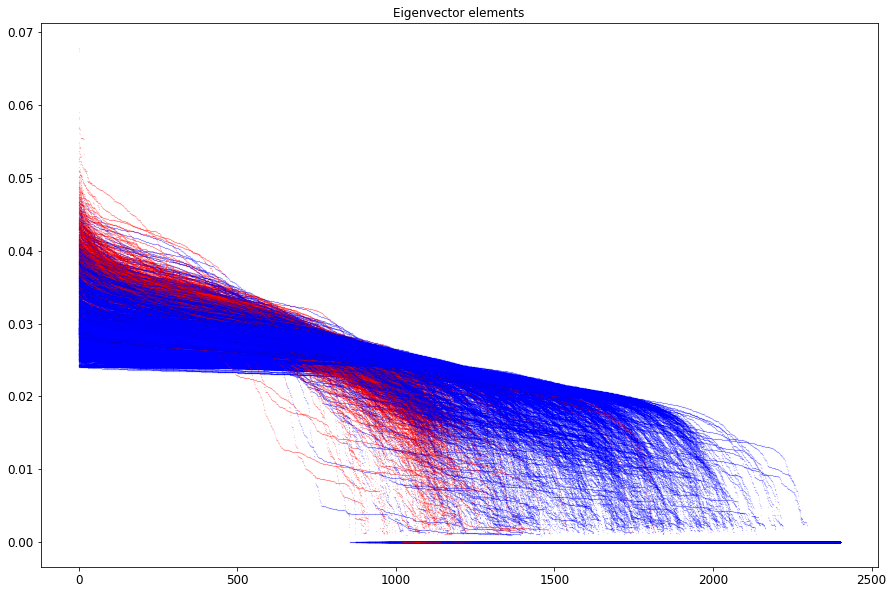

In [10]:
if(plot_figures == True):    
    plt.figure(figsize=(15,10))
    plt.title('Eigenvector elements');
sorted_max_evecs = max_evec
for i in range(m):
    sorted_max_evecs[i] = sort(max_evec[i])[::-1]
    if(plot_figures == True):
        if(classification[i] == failure_label):
            plt.plot(sorted_max_evecs[i,:],'.',markersize=0.1,color='red');
        else:
            plt.plot(sorted_max_evecs[i,:],'.',markersize=0.1,color='blue');

In [11]:
combined_data = c_[classification, sorted_max_evecs]
print(combined_data)
savetxt(filename+'tmp_combined_data.csv',combined_data,fmt='%s',delimiter=',')

[[-1.         0.0258915  0.0258848 ...  0.         0.         0.       ]
 [-1.         0.0259084  0.0259082 ...  0.         0.         0.       ]
 [-1.         0.0257878  0.0257743 ...  0.         0.         0.       ]
 ...
 [-1.         0.0295482  0.0294544 ...  0.         0.         0.       ]
 [-1.         0.0286753  0.0286079 ...  0.         0.         0.       ]
 [-1.         0.0279844  0.0279413 ...  0.         0.         0.       ]]


In [12]:
print('Instances of RO failure detection')
for i in range(num_instances):
    if(classification[i] == 1):
        print(i)

Instances of RO failure detection
383
384
385
386
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
486
487
488
489
490
500
501
535
536
552
553
558
559
563
564
567
568
569
570
574
575
576
577
579
580
581
582
584
585
604
605
606
607
608
609
610
611
615
616
618
619
620
621
648
649
650
651
652
653
654
655
656
657
658
659
660
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
733
734
735
736
737
738
739
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
77